## Problem 6

In [1]:
# Imports
"""
VERSIONS
scipy==1.1.0
scikit-learn==0.21.3
"""
import csv
import numpy as np
import matplotlib.pyplot as plt
import sklearn.discriminant_analysis as skda
import sklearn
import scipy
from sklearn.model_selection import KFold

In [30]:
# Colors and index to use for data
colors = ['#3498DB', '#E74C3C', '#F1C40F']
idx = 0

# Load data
data = []
classes = [[], [], []]
with open('data_3_6.csv') as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    for row in csvReader:
        data.append([float(row[0]), float(row[1]), float(row[2])]) # Not the BEST way of doing this, but mapping float() did weird things.
        if row[2] == '1':
            classes[0].append(list(map(float, row[0:2])))
        elif row[2] == '2':
            classes[1].append(list(map(float, row[0:2])))
        else:
            classes[2].append(list(map(float, row[0:2])))

print("Class 1 length: ", len(classes[0]))
print("Class 2 length: ", len(classes[1]))
print("Class 3 length: ", len(classes[2]))

def print_matrix(m):
    print("Class |  1  |  2  |  3  |")
    print("| 1 |  ", '{0:<5}'.format(m[0][0]), '{0:<5}'.format(m[0][1]), '{0:<5}'.format(m[0][2]))
    print("| 2 |  ", '{0:<5}'.format(m[1][0]), '{0:<5}'.format(m[1][1]), '{0:<5}'.format(m[1][2]))
    print("| 3 |  ", '{0:<5}'.format(m[2][0]), '{0:<5}'.format(m[2][1]), '{0:<5}'.format(m[2][2]))

Class 1 length:  1000
Class 2 length:  500
Class 3 length:  1000


### Problem 6A

Means:  [array([-3.99202896,  4.01559622]), array([3.93202889, 4.11898122]), array([-2.71265961, -0.01185168])]
Sigmas:  [array([[ 3.15511086, -1.082084  ],
       [-1.082084  ,  2.10518773]]), array([[3.43351747, 0.03114848],
       [0.03114848, 5.75450287]]), array([[10.85896586,  0.10843396],
       [ 0.10843396,  3.12917255]])]


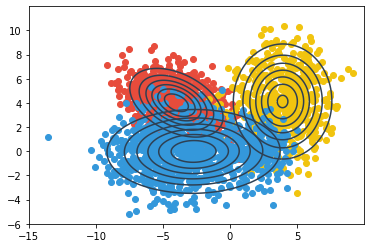

In [3]:
# Loop through each class of data and plot in a different color
for c in classes:
    idx = (idx + 1) % 3
    for pt in c:
        plt.scatter(pt[0], pt[1], color=colors[idx])
    
# Determine multivariate normal distribution parameters for each class
means = [[], [], []]
sigmas = [[], [], []]
for i in range(len(classes)):
    mu = np.mean(classes[i], axis = 0)
    sigma = np.cov(np.array(classes[i]).T) # Convert to NP array and transpose
    means[i] = mu
    sigmas[i] = sigma
    x, y = np.mgrid[-15:10:.01, -6:12:.01]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    rv = scipy.stats.multivariate_normal(mean=mu, cov=sigma)
    # Plot contours showing each distribution
    plt.contour(x, y, rv.pdf(pos), colors='#2E4053')

print("Means: ", means)
print("Sigmas: ", sigmas)

# Put training data in a form so we can fit LDA, QDA and Bayesian models to it
X = np.array(classes[0] + classes[1] + classes[2])
y = np.array([1 for i in range(len(classes[0]))] + [2 for i in range(len(classes[1]))] + [3 for i in range(len(classes[2]))])

### Problem 6B: Priors

Each class prior is a normal distribution with the following mu and sigma parameters:

Class 1 mu: \[\begin{bmatrix}-3.99202896\\4.01559622\end{bmatrix}\]

Class 1 sigma: \[\begin{bmatrix}3.15511086 & -1.082084\\
       1.082084  &  2.10518773\end{bmatrix}\]

Class 2 mu: \[\begin{bmatrix}3.93202889 \\ 4.11898122\end{bmatrix}\]

Class 2 sigma: \[\begin{bmatrix}3.43351747 & 0.03114848 \\ 0.03114848 & 5.75450287\end{bmatrix}\]

Class 3 mu: \[\begin{bmatrix}-2.71265961\\ -0.01185168\end{bmatrix}\]

Class 3 sigma: \[\begin{bmatrix}10.85896586 &  0.10843396 \\ 0.10843396 & 3.12917255\end{bmatrix}\]

### Problem 6C: Naive Bayes Classifier

Confusion Matrix: 
Class |  1  |  2  |  3  |
| 1 |   182   0     12   
| 2 |   2     95    5    
| 3 |   20    7     177  
Best accuracy:  0.908


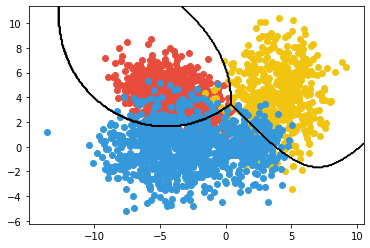

In [27]:
from sklearn.naive_bayes import GaussianNB

# Loop through each class of data and plot in a different color
for c in classes:
    idx = (idx + 1) % 3
    for pt in c:
        plt.scatter(pt[0], pt[1], color=colors[idx])

# Perform 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True)
xvals = np.array(data)[:, 0:2]
yvals = np.array(data)[:, 2]

# Set initial value of accuracy to 0 and confusion matrix blank
accuracy = 0
conf = []

# Run 5-fold cross validation and report stats for run with best accuracy
for train, test in kf.split(xvals):
    correct = 0
    b = GaussianNB()
    b.fit(xvals[train], yvals[train])
    preds = b.predict(xvals[test])
    newconf = sklearn.metrics.confusion_matrix(y_true=yvals[test], y_pred=preds)
    for i in range(0, 3):
        correct += newconf[i][i]
    newacc = correct / len(xvals[test])
    if newacc > accuracy:
        accuracy = newacc
        conf = newconf
    
print("Confusion Matrix: ")
print_matrix(conf)
print("Best accuracy: ", accuracy)
        
# Draw LDA boundaries
nx, ny = 300, 200
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                     np.linspace(y_min, y_max, ny))

Z = b.predict(np.c_[xx.ravel(), yy.ravel()])

# Boundary line
Z1 = Z[:].reshape(xx.shape)
plt.contour(xx, yy, Z1, linewidths=1., colors='k')

### Problem 6D: QDA

Confusion Matrix: 
Class |  1  |  2  |  3  |
| 1 |   192   0     17   
| 2 |   1     82    4    
| 3 |   13    15    176  
Best accuracy:  0.9


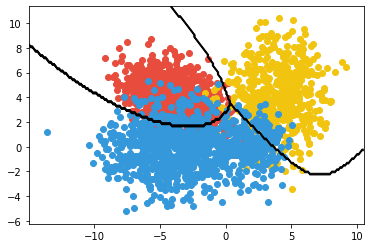

In [29]:
# Loop through each class of data and plot in a different color
for c in classes:
    idx = (idx + 1) % 3
    for pt in c:
        plt.scatter(pt[0], pt[1], color=colors[idx])
        
# Perform 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True)
xvals = np.array(data)[:, 0:2]
yvals = np.array(data)[:, 2]

# Set initial value of accuracy to 0 and confusion matrix blank
accuracy = 0
conf = []

# Run 5-fold cross validation and report stats for run with best accuracy
for train, test in kf.split(xvals):
    correct = 0
    quadratic = skda.QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0, store_covariance=False, tol=0.00001)
    quadratic.fit(xvals[train], yvals[train])
    preds = quadratic.predict(xvals[test])
    newconf = sklearn.metrics.confusion_matrix(y_true=yvals[test], y_pred=preds)
    for i in range(0, 3):
        correct += newconf[i][i]
    newacc = correct / len(xvals[test])
    if newacc > accuracy:
        accuracy = newacc
        conf = newconf
    
print("Confusion Matrix: ")
print_matrix(conf)
print("Best accuracy: ", accuracy)
        
# Draw QDA boundaries
nx, ny = 200, 100
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                     np.linspace(y_min, y_max, ny))

Z = quadratic.predict(np.c_[xx.ravel(), yy.ravel()])

# Boundary line
Z1 = Z[:].reshape(xx.shape)
plt.contour(xx, yy, Z1, linewidths=1., colors='k')

### Problem 6E: LDA

Confusion Matrix: 
Class |  1  |  2  |  3  |
| 1 |   199   0     12   
| 2 |   2     80    5    
| 3 |   19    10    173  
Best accuracy:  0.904


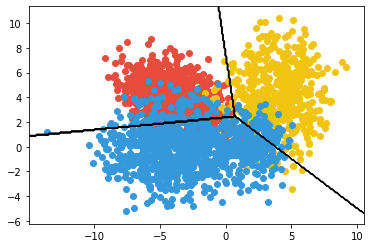

In [28]:
# Loop through each class of data and plot in a different color
for c in classes:
    idx = (idx + 1) % 3
    for pt in c:
        plt.scatter(pt[0], pt[1], color=colors[idx])
        
# Perform 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True)
xvals = np.array(data)[:, 0:2]
yvals = np.array(data)[:, 2]

# Set initial value of accuracy to 0 and confusion matrix blank
accuracy = 0
conf = []

# Run 5-fold cross validation and report stats for run with best accuracy
for train, test in kf.split(xvals):
    correct = 0
    linear = skda.LinearDiscriminantAnalysis()
    linear.fit(xvals[train], yvals[train])
    preds = linear.predict(xvals[test])
    newconf = sklearn.metrics.confusion_matrix(y_true=yvals[test], y_pred=preds)
    for i in range(0, 3):
        correct += newconf[i][i]
    newacc = correct / len(xvals[test])
    if newacc > accuracy:
        accuracy = newacc
        conf = newconf
        
print("Confusion Matrix: ")
print_matrix(conf)
print("Best accuracy: ", accuracy)

# Draw LDA boundaries
nx, ny = 300, 200
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                     np.linspace(y_min, y_max, ny))

Z = linear.predict(np.c_[xx.ravel(), yy.ravel()])

# Boundary line
Z1 = Z[:].reshape(xx.shape)
plt.contour(xx, yy, Z1, linewidths=1., colors='k')

### Problem 6F: Discussion
Each classifier had a very similar performance, typically ranging from 88% to 91% accuracy depending on how data are randomly partitioned into train vs. test for the 5-fold cross-validation. Considering how similar the performance of each method was, and looking at how much the data overlap each other, I don't think using a different kind of classifier would improve performance significantly.